# In this notebook we will explore Canada Goose migration data from the MoveBank database.

# To follow this notebook, please download the raw CSV file [here](https://www.movebank.org/cms/webapp?gwt_fragment=page=studies,path=study2105214573).

In this notebook we will:

* Read the data
* Group points by individual geese
* Split points into tracks using spatiotemporal splitting
* Reproject the data CRS
* Plot the data
* Compute speeds and coursing along tracks
* Classify stops in the data
* Develop distributions of time spent stopped
* Develop a unstructured traffic graph

___

In [1]:
import trackio as tio
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import  DBSCAN
import pandas as pd
import geopandas as gp

## First, I will make a column mapper so I know what's in the data.

In [2]:
#define the files
files = ['North-East American Canada goose migration 2015-2021.csv']

In [3]:
#make a column mapper for raw data
col_mapper = tio.make_col_mapper(files, 
                                 ncores=1)
                                 
col_mapper

Making column mapper: 100%|██████████| 1/1 [00:00<00:00, 500.69it/s]


{'event-id': 'event-id',
 'height-raw': 'height-raw',
 'individual-local-identifier': 'individual-local-identifier',
 'individual-taxon-canonical-name': 'individual-taxon-canonical-name',
 'location-lat': 'location-lat',
 'location-long': 'location-long',
 'sensor-type': 'sensor-type',
 'study-name': 'study-name',
 'tag-local-identifier': 'tag-local-identifier',
 'timestamp': 'timestamp',
 'visible': 'visible'}

## You can see that there's `timestamp`, `location-long`, and `location-lat` columns in the files.

In [4]:
#edit the mapper
col_mapper['timestamp'] = 'Time'
col_mapper['location-long'] = 'X'
col_mapper['location-lat'] = 'Y'

## Now let's group the points.

In [5]:
#create the dataset
ds = tio.read(raw_files=files,
              data_path='bird_data')


No dataset.db found in c:\code\trackio\notebooks\example3_Canada_Goose_migrations\bird_data. 
Using default units/crs. 
Edit self.meta and then run self.refresh_meta to update.



In [6]:
#group the points by agent
ds = ds.group_points(groupby='individual-local-identifier',
                     col_mapper=col_mapper,                
                     meta_cols=['tag-local-identifier',
                                'individual-local-identifier',
                                'sensor-type'],
                     data_cols=['Time',
                                'X',
                                'Y',
                                'height-raw'],
                     prefix='Goose_',
                     ncores=1)

Grouping points: 100%|██████████| 1/1 [00:11<00:00, 11.72s/it]


## Now let's split the points into tracks.

Notice that there does not seem to be a unique track identifier in the raw columns. But, the description of the data from the online source (and from peeking at the data) shows there is data across multiple years, and likely multiple tracks per agent. The website notes sub-hour reporting of positions. To be safe, it's decided to use a 4 week gap between points to be sure intermittent tracks aren't being split.

In [7]:
#split using spatiotemporal thresholds
ds = ds.split_tracks_spatiotemporal(time=3600*24*7*4,
                                    distance=1e6, #make large so splits only happen at temporal gaps
                                    ncores=4)

Splitting tracks using spatiotemporal threshold: 100%|██████████| 82/82 [00:02<00:00, 37.14it/s]


## Let's also reproject so we can calculate some fields easier later on

In [8]:
#reproject to 3857
ds = ds.reproject_crs(3857)

Reprojecting CRS: 100%|██████████| 82/82 [00:01<00:00, 79.34it/s]


In [9]:
#refresh the metadata
ds = ds.refresh_meta()

Refreshing metadata: 100%|██████████| 82/82 [00:01<00:00, 72.37it/s]

New meta/databases saved to c:\code\trackio\notebooks\example3_Canada_Goose_migrations\bird_data


In [10]:
ds.agents.head(5)

,tag-local-identifier,individual-local-identifier,sensor-type,npoints,ntracks,Xmin,Xmax,Ymin,Ymax,Start Time,End Time,File,geometry
Agent ID,,,,,,,,,,,,,
Goose_1208-75647,s89460800120046872535,1208-75647,gps,2345,1,-8781507.939868,-8402736.915913,5860770.77653,6796713.331572,2018-09-16 05:11:22,2018-11-05 10:41:24,c:\code\trackio\notebooks\example3_Canada_Goos...,"POLYGON ((-8402736.916 5860770.777, -8402736.9..."
Goose_1158-64308,s89460800120046860811,1158-64308,gps,73019,1,-8727669.937938,-8158748.303146,4579506.052531,8316518.355946,2017-08-11 05:12:24,2021-05-10 13:07:37,c:\code\trackio\notebooks\example3_Canada_Goos...,"POLYGON ((-8158748.303 4579506.053, -8158748.3..."
Goose_1158-64149,s89460800120046859755,1158-64149,gps,8804,1,-8617636.298583,-8222377.856166,4690174.430816,8370967.949732,2017-08-09 05:03:36,2017-11-22 11:59:28,c:\code\trackio\notebooks\example3_Canada_Goos...,"POLYGON ((-8222377.856 4690174.431, -8222377.8..."
Goose_1278-00112,s182874,1278-00112,gps,26787,1,-8603463.991571,-7680012.15382,5030818.083524,8280451.60201,2019-08-08 05:07:21,2020-05-14 17:45:53,c:\code\trackio\notebooks\example3_Canada_Goos...,"POLYGON ((-7680012.154 5030818.084, -7680012.1..."
Goose_1208-75651,s89460800120046876890,1208-75651,gps,5044,1,-8796025.003342,-8504527.346975,5230365.73134,6791519.181348,2018-09-16 05:11:35,2019-03-01 10:36:23,c:\code\trackio\notebooks\example3_Canada_Goos...,"POLYGON ((-8504527.347 5230365.731, -8504527.3..."


In [11]:
ds.tracks.head(5)

,tag-local-identifier,individual-local-identifier,sensor-type,Agent ID,npoints,Xmin,Xmax,Ymin,Ymax,Start Time,...,Yend,Effective Distance,Min Temporal Resolution,Mean Temporal Resolution,Max Temporal Resolution,Min Spatial Resolution,Mean Spatial Resolution,Max Spatial Resolution,Sinuosity,geometry
Track ID,,,,,,,,,,,,,,,,,,,,,
Goose_1208-75647_T0,s89460800120046872535,1208-75647,gps,Goose_1208-75647,2345,-8.781508e+06,-8.402737e+06,5.860771e+06,6.796713e+06,2018-09-16 05:11:22,...,5.862678e+06,9.994751e+05,38,1851.451365,1229990,0.0,619.122428,9.943468e+05,1.451985,"POLYGON ((-8402736.916 5860770.777, -8402736.9..."
Goose_1158-64308_T0,s89460800120046860811,1158-64308,gps,Goose_1158-64308,73019,-8.727670e+06,-8.158748e+06,4.579506e+06,8.316518e+06,2017-08-11 05:12:24,...,5.854482e+06,2.431822e+06,95,1619.103687,244501,0.0,637.490837,1.321317e+06,19.141332,"POLYGON ((-8158748.303 4579506.053, -8158748.3..."
Goose_1158-64149_T0,s89460800120046859755,1158-64149,gps,Goose_1158-64149,8804,-8.617636e+06,-8.222378e+06,4.690174e+06,8.370968e+06,2017-08-09 05:03:36,...,4.811897e+06,3.559129e+06,137,1033.392253,7039,0.0,624.053960,7.069043e+04,1.543509,"POLYGON ((-8222377.856 4690174.431, -8222377.8..."
Goose_1278-00112_T0,s182874,1278-00112,gps,Goose_1278-00112,26787,-8.603464e+06,-7.680012e+06,5.030818e+06,8.280452e+06,2019-08-08 05:07:21,...,6.210881e+06,2.074361e+06,1,904.857463,12657,0.0,373.240532,9.891049e+04,4.819615,"POLYGON ((-7680012.154 5030818.084, -7680012.1..."
Goose_1208-75651_T0,s89460800120046876890,1208-75651,gps,Goose_1208-75651,5044,-8.796025e+06,-8.504527e+06,5.230366e+06,6.791519e+06,2018-09-16 05:11:35,...,5.241589e+06,1.571436e+06,38,2847.885782,135671,0.0,730.194769,1.879955e+05,2.343317,"POLYGON ((-8504527.347 5230365.731, -8504527.3..."


In [12]:
ds.tracks[['Start Time','End Time','Duration']]

,Start Time,End Time,Duration
Track ID,,,
Goose_1208-75647_T0,2018-09-16 05:11:22,2018-11-05 10:41:24,4339802
Goose_1158-64308_T0,2017-08-11 05:12:24,2021-05-10 13:07:37,118223713
Goose_1158-64149_T0,2017-08-09 05:03:36,2017-11-22 11:59:28,9096952
Goose_1278-00112_T0,2019-08-08 05:07:21,2020-05-14 17:45:53,24237512
Goose_1208-75651_T0,2018-09-16 05:11:35,2019-03-01 10:36:23,14361888
...,...,...,...
Goose_1208-75589_T2,2019-09-01 23:37:04,2019-11-27 11:26:20,7472956
Goose_1208-75663_T0,2018-09-17 05:08:07,2018-09-23 04:51:06,517379
Goose_1208-75644_T0,2018-09-16 05:11:53,2018-11-26 13:58:55,6166022


## Some basic information about the data


In [13]:
print(len(ds.agents), 'Geese')
print(len(ds.tracks), 'Tracks')
print(ds.agents.npoints.sum(), 'Points')
print('From', ds.agents['Start Time'].min(), 'to', ds.agents['End Time'].max())
print('Mean Spatial Resolution', ds.tracks['Mean Spatial Resolution'].mean(), 'm')
print('Mean Temporal Resolution', ds.tracks['Mean Temporal Resolution'].mean(), 's')

82 Geese
98 Tracks
1681153 Points
From 2015-04-26 05:13:09 to 2021-06-24 17:24:05
Mean Spatial Resolution 723.6081559119358 m
Mean Temporal Resolution 2001.930391255995 s


## Let's plot them quickly on a basemap


In [14]:
#Convert to GeoDataFrame.. here you can export to software like QGIS to play with the data
gdf = ds.to_gdf(ncores=4)

Converting tracks to GeoDataFrame: 100%|██████████| 82/82 [00:02<00:00, 30.22it/s] 


<Axes: >

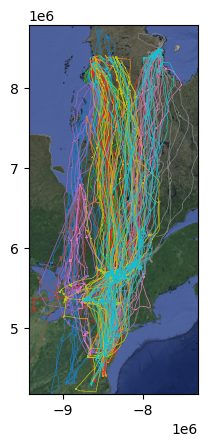

In [15]:
#plot
plt.figure()
bm = rio.open('basemap.tif', 'r')
ax = show(bm, zorder=0, ax=plt.gca())
gdf.plot(column='individual-local-identifier', ax=plt.gca(), zorder=1, linewidth=0.5)

## Let's compute the speeds so we can identify some stops

In [16]:
#compute speeds
ds = ds.compute_speed()

Computing speed: 100%|██████████| 82/82 [00:00<00:00, 297.64it/s]


## Let's try to identify stops using a speed and duration threshold

In [17]:
#classify stops
ds = ds.classify_stops(stop_threshold=0.25,
                       min_stop_duration=12*3600,
                       code=22)

Classifying stopped tracks: 100%|██████████| 82/82 [00:02<00:00, 34.01it/s]


In [18]:
#refresh the metadata
ds = ds.refresh_meta()

Refreshing metadata: 100%|██████████| 82/82 [00:01<00:00, 70.00it/s]

New meta/databases saved to c:\code\trackio\notebooks\example3_Canada_Goose_migrations\bird_data


## Now, let's plot the stops and see if we notice any obvious clustering.

In [19]:
#convert to dataframe
df = ds.to_df(agents=ds.agents.index[ds.agents['Code22']], 
              ncores=1, 
              code=22)

Converting tracks to DataFrame: 100%|██████████| 82/82 [00:00<00:00, 84.15it/s]


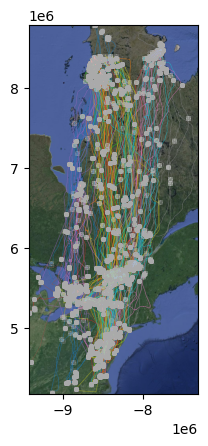

In [20]:
#plot the stops
plt.figure()
bm = rio.open('basemap.tif', 'r')
ax = show(bm, zorder=0, ax=plt.gca())
gdf.plot(column='individual-local-identifier', ax=plt.gca(), alpha=0.5, zorder=1, linewidth=0.5)
plt.scatter(df['X'], df['Y'], c='w', alpha=0.01, s=10)

## Let's plot a distribution of the % of time spent resting for each track

In [21]:
#define function to count time spent stopped
def time_spent_stopped(agent):
    out = []
    for _track_id in agent.tracks.keys():
        #initialize stop count
        stop_duration = 0
        #get track and track id
        track = agent.tracks[_track_id][['Time','Code22']]
        track_id = agent.track_meta[_track_id]['Track ID']
        #find splits from stopped/moving
        split_ids = np.nonzero(np.diff(track['Code22'].values))[0] + 1
        time_groups = np.split(track['Time'], split_ids)
        code_groups = np.split(track['Code22'], split_ids)
        #loop over track segments/groups
        for c_group, t_group in zip(code_groups, time_groups):
            #if stopped and > 1 point
            if np.all(c_group) and len(c_group) > 1:
                #get duration of stop
                dt = (t_group.iloc[-1] - t_group.iloc[0]).total_seconds()
                #add to track stop duration, if multiple stops
                stop_duration += dt
            else:
                pass
        #append to output
        out.append((track_id, stop_duration))
    return out

In [22]:
#calculate time stopped
time_stopped = ds.to_dask_bag().map(time_spent_stopped).compute()

In [23]:
#flatten the list
time_stopped = [sub for l in time_stopped for sub in l]

In [24]:
#convert to pandas dataframe
df = pd.DataFrame(np.array(time_stopped), columns=['Track ID','Time Stopped'])
df['Time Stopped'] = df['Time Stopped'].astype(float)
df['Track Duration'] = ds.tracks.loc[df['Track ID'], 'Duration'].values
df['% Stopped'] = 100 * df['Time Stopped']/df['Track Duration']

<Axes: ylabel='Frequency'>

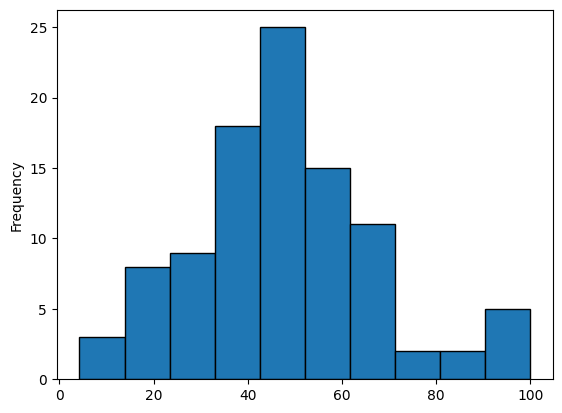

In [25]:
#plot histogram of stop durations
df['% Stopped'].plot.hist(bins=10, edgecolor='k')

C:\Users\dere\AppData\Local\Temp\ipykernel_17492\205514388.py:5: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gdf.iloc[[gdf['Duration'].argmax()]].plot(column='individual-local-identifier', ax=plt.gca(), zorder=1, linewidth=0.5, color='r')


<Axes: >

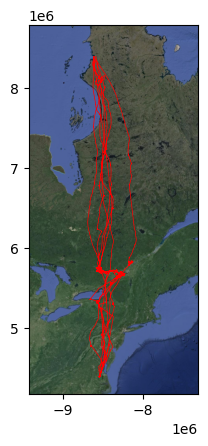

In [26]:
## Plot the track with the longest history of records
plt.figure()
bm = rio.open('basemap.tif', 'r')
ax = show(bm, zorder=0, ax=plt.gca())
gdf.iloc[[gdf['Duration'].argmax()]].plot(ax=plt.gca(), zorder=1, linewidth=0.5, color='r')

## Let's reduce the data to a representative graph / flow diagram.

To do this, we'll first extract the characteristic points from the tracks. Then, we'll cluster them and use the cluster centroids to generate a voronoi diagram through which the tracks will be routed.

In [27]:
#first we need to compute coursing for the characteristic track algorithm
ds = ds.compute_coursing()

Computing coursing: 100%|██████████| 82/82 [00:00<00:00, 171.55it/s]


In [28]:
#reduce to characteristic, write to another folder
char = ds.characteristic_tracks(stop_threshold=0.15,
                         turn_threshold=22.5,
                         min_distance=20000,
                         max_distance=5000000,
                         min_stop_duration=12*3600,
                         inplace=True,
                         out_path='characteristic',
                         ncores=4)

#refresh meta
char = char.refresh_meta()

Refreshing metadata: 100%|██████████| 82/82 [00:01<00:00, 79.34it/s]

New meta/databases saved to c:\code\trackio\notebooks\example3_Canada_Goose_migrations\characteristic


## Notice the new Dataset is created.

In [29]:
ds.data_path, char.data_path

('c:\\code\\trackio\\notebooks\\example3_Canada_Goose_migrations\\bird_data',
 'c:\\code\\trackio\\notebooks\\example3_Canada_Goose_migrations\\characteristic')

## Let's plot the characteristic points over the tracks to visualize

In [30]:
#convert to dataframe
char_df = char.to_df()

Converting tracks to DataFrame: 100%|██████████| 82/82 [00:00<00:00, 113.03it/s]


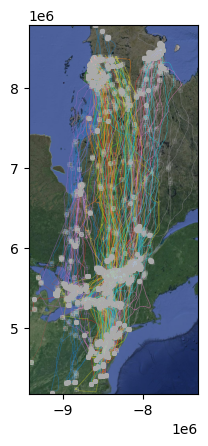

In [31]:
#plot the stops
plt.figure()
bm = rio.open('basemap.tif', 'r')
ax = show(bm, zorder=0, ax=plt.gca())
gdf.plot(column='individual-local-identifier', ax=plt.gca(), alpha=0.5, zorder=1, linewidth=0.5)
plt.scatter(char_df['X'], char_df['Y'], c='w', alpha=0.01, s=10)

## Now let's perform a density based spatial clustering using `scipy`'s `DBSCAN` function.

In [32]:
#get the coordinates
data = char_df[['X','Y']].copy()

#transform data for DBSCAN
scaler = StandardScaler()
data = scaler.fit_transform(data)

dbscan = DBSCAN(eps=0.05, 
                min_samples=7)

#get labels
labels = dbscan.fit(data).labels_

#get centroids
centroids = char_df[['X','Y']].groupby(labels).agg('mean')

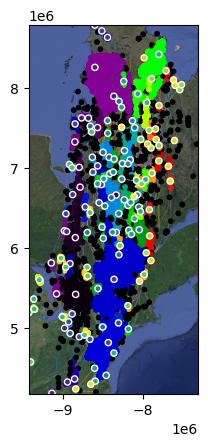

In [33]:
#plot the clusters
plt.figure()
bm = rio.open('basemap.tif', 'r')
ax = show(bm, zorder=0, ax=plt.gca())
gdf.plot(column='individual-local-identifier', ax=plt.gca(), alpha=0.5, zorder=1, linewidth=0.5)
plt.scatter(char_df['X'], char_df['Y'], c=labels, s=10, cmap='nipy_spectral')
plt.scatter(centroids['X'], centroids['Y'], c=centroids.index, edgecolor='w', s=20)

## It ended up looking a bit messy, let's cluster the centroids one more time

In [34]:
#get the coordinates
data = centroids[['X','Y']].copy()

#transform data for DBSCAN
scaler = StandardScaler()
data = scaler.fit_transform(data)

dbscan = DBSCAN(eps=0.2, 
                min_samples=1)

#get labels
labels = dbscan.fit(data).labels_

#get centroids
new_centroids = centroids[['X','Y']].groupby(labels).agg('mean')

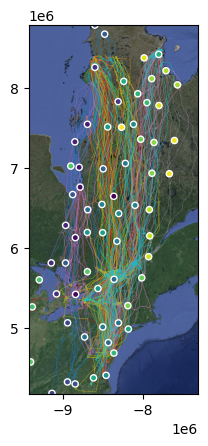

In [35]:
#plot the clusters
plt.figure()
bm = rio.open('basemap.tif', 'r')
ax = show(bm, zorder=0, ax=plt.gca())
gdf.plot(column='individual-local-identifier', ax=plt.gca(), alpha=0.5, zorder=1, linewidth=0.5)
plt.scatter(new_centroids['X'], new_centroids['Y'], c=new_centroids.index, edgecolor='w', s=20)

## Now we can create our voronoi diagram


In [36]:
#create voronoi diagram from cluster centroids
centroids_gdf = gp.GeoDataFrame(new_centroids)
centroids_gdf.geometry = gp.points_from_xy(centroids_gdf['X'], centroids_gdf['Y'])
centroids_gdf.crs = 3857
voronoi = tio.utils.create_voronoi(centroids_gdf,buffer=1e8)

<Axes: >

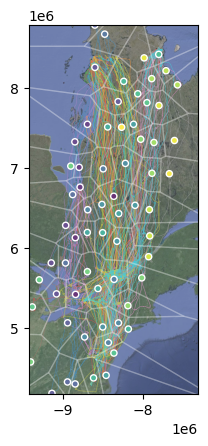

In [37]:
#plot the clusters
plt.figure()
bm = rio.open('basemap.tif', 'r')
ax = show(bm, zorder=0, ax=plt.gca())
gdf.plot(column='individual-local-identifier', ax=plt.gca(), alpha=0.5, zorder=1, linewidth=0.5)
plt.xlim(plt.gca().get_xlim())
plt.ylim(plt.gca().get_ylim())
plt.scatter(new_centroids['X'], new_centroids['Y'], c=new_centroids.index, edgecolor='w', s=20)
voronoi.plot(ax=plt.gca(), edgecolor='w', facecolor='w', alpha=0.2)

## Notice that `voronoi` is a GeoDataFrame with a `Code` column

In [38]:
voronoi.head(5)

,geometry,Code,X,Y
0,"POLYGON ((-6928989.963 4027930.713, -8254392.7...",1,-8.179648e+06,4.984686e+06
1,"POLYGON ((-8254392.746 4825620.289, -6928989.9...",2,-8.359952e+06,4.685101e+06
2,"POLYGON ((-8578914.829 4605180.389, -6928989.9...",3,-8.457535e+06,4.406186e+06
3,"POLYGON ((-8254392.746 4825620.289, -8613180.7...",4,-8.429852e+06,4.815489e+06
4,"POLYGON ((-8613180.774 4633278.220, -8578914.8...",5,-8.614393e+06,4.374804e+06


## Now we will classify the points inside these polygons, and generate a flow map based on how they route through the polygons.

In [39]:
#classify polygons
ds = ds.classify_in_polygons(voronoi,
                             to_codes=False,
                             name='Polygon',
                             ncores=4)

Classifying tracks inside polygons: 100%|██████████| 82/82 [00:05<00:00, 15.35it/s]


In [40]:
#generate flow map
flow = ds.generate_flow_map(voronoi,
                            flow_col='Polygon',
                            ncores=4)

Generating flow map from polygons: 100%|██████████| 82/82 [00:02<00:00, 28.20it/s] 


## Now let's plot the flow map

<Axes: >

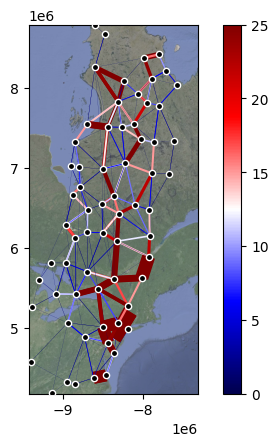

In [41]:
#plot the flow map
plt.figure()
bm = rio.open('basemap.tif', 'r')
ax = show(bm, zorder=0, ax=plt.gca(), alpha=0.75)
plt.scatter(new_centroids['X'], new_centroids['Y'], c='k', edgecolor='w', s=20, zorder=3)
flow.plot(ax=plt.gca(), column='Volume', vmin=0, vmax=25, linewidth=flow['Volume']/10, cmap='seismic', legend=True)